**Deep Learning AA 2022/2023**
** **
Teachers:\
Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)\
Antonio Purificato (antonio.purificato@uniroma1.it)\
Farooq Wani (wani@diag.uniroma1.it)\
Maria Sofia Bucarelli (bucarelli@diag.uniroma1.it) \

**What is SemEval?**

SemEval is a series of international natural language processing (NLP) research workshops whose mission is to advance the current state of the art in semantic analysis and to help create high-quality annotated datasets in a range of increasingly challenging problems in natural language semantics. Each year's workshop features a collection of shared tasks in which computational semantic analysis systems designed by different teams are presented and compared.

**SemEval 2021 Task 6 Subtask 1**

Given only the “textual content” of a meme, identify which of the 20 techniques are used in it. This is a multilabel classification problem.
The input data for task 1 is the text extracted from the meme. The training, the development and the test sets for task 1 are distributed as json files.

The entry for that example in the json file for Task 1 is

		{
			"id": "125",
			"text": "I HATE TRUMP\n\nMOST TERRORIST DO",
			"labels": [
				"Loaded Language",
				"Name calling/Labeling"
				]
		},

# Initialization

In [1]:
# Mount Google Drive
from google.colab import drive  # import drive from google colab

ROOT = "/content/drive"  # default location for the drive

drive.mount(ROOT)  # we mount the google drive at /content/drive

Mounted at /content/drive


# Setup
⚠️ The first time you use this notebook run this cell, then comment **ONLY** it. ⚠️

To download the files we use [gdown](https://github.com/wkentaro/gdown)!

In [2]:
%%capture
!pip install -U --no-cache-dir gdown --pre
import gdown
%cd /content/drive/MyDrive
!mkdir Practicum_3_folder
%cd Practicum_3_folder
url = 'https://drive.google.com/drive/folders/1-yXLITJWJi1A05tixdcmsjOw85UDz3jd?usp=sharing'
gdown.download_folder(url, quiet=True)

!git clone https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus.git
%cd SEMEVAL-2021-task6-corpus/data
!unzip dev_set_task3.zip
!unzip training_set_task3.zip
!unzip test_set_task3.zip
!mv  dev_set_task3_labeled/dev_set_task3_labeled.txt .
!mv  training_set_task3/training_set_task3.txt .
!mv  test_set_task3/test_set_task3.txt .
%cd ../..

In [3]:
%%capture
%cd ./drive/MyDrive/Practicum_3_folder/

# Download and import

In [4]:
%%capture
!pip install "pytorch-lightning" "torchmetrics" "transformers" "prettytable"

In [5]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from PIL import Image

from prettytable import PrettyTable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models import resnet50

from torchmetrics import functional

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    AutoConfig,
    get_constant_schedule_with_warmup,
)

In [6]:
seed_everything(21)

INFO:lightning_fabric.utilities.seed:Seed set to 21


21

# Datasets definitions

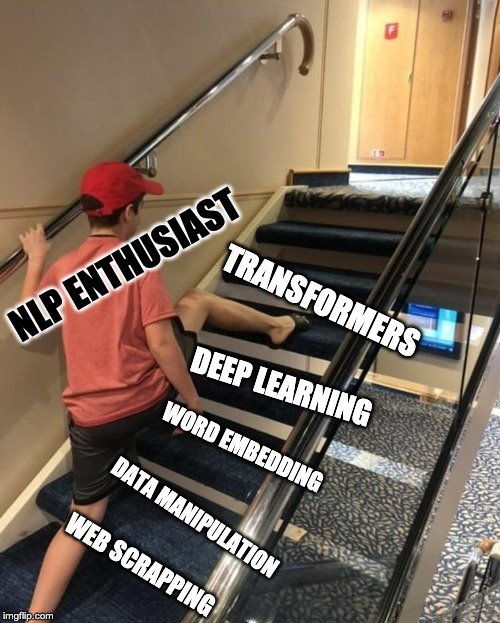

Here the dataset classes that are going to be used in the project are defined.

We transform the labels into fixed sized vectors by using the `MultiLabelBinarizer` function from [*sklearn.preprocessing*](https://scikit-learn.org/stable/modules/preprocessing.html).

The `PersTecData` and `PersTecDataEnsemble` classes extend the *torch* `Dataset` class.

`PersTecData` takes as input:

* the *data_type* (= training/dev/test)
* *task* (= 1)
* *tokenizer* = None
* *transforms* = None

If a tokenizer is passed the texts of the samples are saved already tokenized.

`PersTecDataEnsemble` is similar but takes a list of tokenizers. It returns a list where each element is the text of the sample tokenized by the corresponding tokenizer, together with the corresponding label. It is used in task 1, with the ensemble of models, since each model needs a different tokenization of the input.

In [7]:
DATA_DIR = "/content/drive/MyDrive/Practicum_3_folder/SEMEVAL-2021-task6-corpus/data/"

In [8]:
my_binarizer_task1 = MultiLabelBinarizer()
classes_file = "./SEMEVAL-2021-task6-corpus/techniques_list_task1-2.txt"
labels_name1 = []
with open(classes_file, "r") as f:
    for line in f.readlines():
        labels_name1.append(line.rstrip())
labels_name1.pop(-1)
labels_name1.sort()  # MultiLabelBinarizer sorts the labels
my_binarizer_task1.fit([labels_name1]);

In [9]:
my_binarizer_task3 = MultiLabelBinarizer()
classes_file = "./SEMEVAL-2021-task6-corpus/techniques_list_task3.txt"
labels_name3 = []
with open(classes_file, "r") as f:
    for line in f.readlines():
        labels_name3.append(line.rstrip())
labels_name3.pop(-1)
labels_name3.sort()  # MultiLabelBinarizer sorts the labels
my_binarizer_task3.fit([labels_name3]);

In [10]:
#Function to load the data
def load_data(data_type, task):
    all_idxs = []
    file_name = "%s_set_task%d.txt" % (data_type, task)
    if task == 3 and data_type == "dev":
        df = pd.read_json(DATA_DIR + "dev_set_task3_labeled.txt")
    else:
        df = pd.read_json(os.path.join(DATA_DIR, file_name))
    all_idxs = df["id"].to_numpy()
    all_data = df["text"].to_numpy()
    if task == 3:
        all_images = df["image"].to_numpy()
        all_labels = my_binarizer_task3.transform(df["labels"])
    else:
        all_images = None
        all_labels = my_binarizer_task1.transform(df["labels"])
    return all_idxs, all_data, torch.tensor(all_labels), all_images

##Dataset class for single models
PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

A custom Dataset class must implement three functions: `__init__`, `__len__` and `__get_item__`.

In [11]:
class PersTecData(torch.utils.data.Dataset):
    def __init__(self, data_type="training", task=1, tokenizer=None, transforms=None):
        idxs, X, self.y, self.image = load_data(data_type, task)
        self.tokenized = False
        if tokenizer != None:
            self.tokenized = True
            tokenized = tokenizer(
                X.tolist(), padding="max_length", truncation=True, max_length=128
            )
            self.input_ids = torch.tensor(tokenized["input_ids"])
            self.attention_mask = torch.tensor(tokenized["attention_mask"])
        else:
            self.X = X
        self.transforms = transforms
        self.task = task
        self.data_type = data_type

    def __getitem__(self, index):
        if self.task == 3:
            if self.data_type == "training":
                path = DATA_DIR + "training_set_task3/"
            if self.data_type == "dev":
                path = DATA_DIR + "dev_set_task3_labeled/"
            if self.data_type == "test":
                path = DATA_DIR + "test_set_task3/"
            image = Image.open(path + str(self.image[index])).convert("RGB")
            image = self.transforms(image)
            if self.tokenized:
                sample = self.input_ids[index]
                mask = self.attention_mask[index]
                label = torch.squeeze(self.y[index])
                return sample, mask, label, image
            else:
                sample = self.X[index]
                label = np.squeeze(self.y[index])
                return sample, label, image
        else:
            if self.tokenized:
                sample = self.input_ids[index]
                mask = self.attention_mask[index]
                label = torch.squeeze(self.y[index])
                return sample, mask, label
            else:
                sample = self.X[index]
                label = np.squeeze(self.y[index])
                return sample, label

    def __len__(self):
        if self.tokenized:
            return self.input_ids.shape[0]
        else:
            return self.X.shape[0]

In [12]:
#Dataset class for ensembles of models
class PersTecDataEnsemble(torch.utils.data.Dataset):
    def __init__(self, data_type="training", task=1, tokenizers=None, transforms=None):
        self.idxs, self.X, self.y, self.image = load_data(data_type, task)
        self.data_type = data_type
        self.num_tok = len(tokenizers)
        self.input_ids = []
        self.attention_mask = []
        self.task = task
        for tokenizer in tokenizers:
            tokenized = tokenizer(
                self.X.tolist(), padding="max_length", truncation=True, max_length=128
            )
            self.input_ids.append(torch.tensor(tokenized["input_ids"]))
            self.attention_mask.append(torch.tensor(tokenized["attention_mask"]))

    def __getitem__(self, index):
        elem = []
        if self.task == 3:
            if self.data_type == "training":
                path = DATA_DIR + "training_set_task3/"
            if self.data_type == "dev":
                path = DATA_DIR + "dev_set_task3_labeled/"
            if self.data_type == "test":
                path = DATA_DIR + "test_set_task3/"
            image = Image.open(path + str(self.image[index])).convert("RGB")
            image = self.transforms(image)

            for i in range(self.num_tok):
                sample = self.input_ids[i][index]
                mask = self.attention_mask[i][index]
                label = torch.squeeze(self.y[index])
                elem.append([sample, mask, label, image])
            return elem
        else:
            for i in range(self.num_tok):
                sample = self.input_ids[i][index]
                mask = self.attention_mask[i][index]
                label = torch.squeeze(self.y[index])
                elem.append([sample, mask, label])
            return elem

    def __len__(self):
        return self.X.shape[0]

# Architectures of the models

Here all the models used in this project are defined. The models used are:
* `PLMClassifier`
* `EnsembleClassifier`

`PLMClassifier` uses a pretrained language model and fine-tunes it on the selected task.

`EnsembleClassifier` uses a list of `PLMClassifier` and averages their results to predict. This class is only used for inference, so the models need to be trained beforehand.


## `PLMClassifier` class

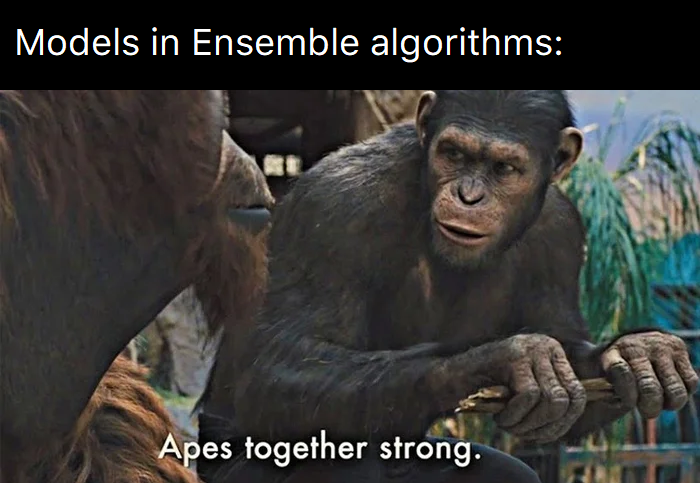

In [13]:
class PLMClassifier(pl.LightningModule):
    def __init__(self, plm, output_dim=20):
        super().__init__()
        self.plm = plm
        self.learning_rate = 2e-5
        self.n_warmup_steps = 500
        self.criterion = nn.BCELoss()

    def forward(self, samples, masks):
        x = self.plm(samples, masks)
        return torch.sigmoid(x.logits)

    def training_step(self, batch, batch_idx):
        if TASK == 1:
            batch_ids, batch_mask, labels = batch
        if TASK == 3:
            batch_ids, batch_mask, labels, _ = batch
        preds = self(samples=batch_ids, masks=batch_mask)
        loss = self.criterion(preds, labels.float())
        self.log("train_loss", loss.item())
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        if TASK == 1:
            batch_ids, batch_mask, labels = batch
        if TASK == 3:
            batch_ids, batch_mask, labels, _ = batch
        preds = self(samples=batch_ids, masks=batch_mask)
        val_loss = self.criterion(preds, labels.float())
        self.log("val_loss", val_loss.item())
        return {"loss": val_loss}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = get_constant_schedule_with_warmup(
            optimizer, num_warmup_steps=self.n_warmup_steps
        )
        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step")
        )

## `EnsembleClassifier` class

In [14]:
class EnsembleClassifier(pl.LightningModule):
    def __init__(self, models):
        super().__init__()
        self.models = []
        for model in models:
            self.models.append(model)
        self.n_models = len(self.models)

    def forward(self, batch):
        preds = []
        for i, model in enumerate(self.models):
            samples, masks, _ = batch[i]
            device = model.device
            samples = samples.to(device)
            masks = masks.to(device)
            x = model(samples, masks)
            preds.append(x)
        preds = torch.stack(preds)
        pred = torch.mean(preds, axis=0)
        return pred

**TASK 1**

Task 1 consists in finding the persuasion techniques used in a meme by only analizing its textual part. Three different pretrained language models are used:

* `BERT`
* `RoBERTa`
* `XLNet`

The pretrained models are taken from [Hugging Face](https://huggingface.co/docs/transformers/index#); they are then fine-tuned on our task. At the end an ensemble is created that averages the predictions of all the models. In the tabels we can see the results obtained for this task on the validation set and on the test set.

In [15]:
# setting global parameters used while defining the models
TASK = 1
transforms = None
NUM_LABELS = 20

# Datasets creation
Each model has its set of datasets, where each sample is tokenized with the respective tokenizer.

## Baseline datasets

In [16]:
%%capture
dataset_train1_baseline = PersTecData(
    data_type="training", task=TASK, tokenizer=None, transforms=transforms
)

dataset_val1_baseline = PersTecData(
    data_type="dev", task=TASK, tokenizer=None, transforms=transforms
)

dataset_test1_baseline = PersTecData(
    data_type="test", task=TASK, tokenizer=None, transforms=transforms
)

## `BERT` datasets

In [17]:
%%capture
tokenizer1 = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

dataset_train1_BERT = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer1, transforms=transforms
)
train_loader_BERT = DataLoader(
    dataset_train1_BERT, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_BERT = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer1, transforms=transforms
)
val_loader_BERT = DataLoader(
    dataset_val1_BERT, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_BERT = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer1, transforms=transforms
)
test_loader_BERT = DataLoader(
    dataset_test1_BERT, batch_size=8, num_workers=2, pin_memory=True
)

## `RoBERTa` datasets

In [18]:
%%capture
tokenizer2 = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
dataset_train1_RoBERTa = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer2, transforms=transforms
)
train_loader_RoBERTa = DataLoader(
    dataset_train1_RoBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_RoBERTa = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer2, transforms=transforms
)
val_loader_RoBERTa = DataLoader(
    dataset_val1_RoBERTa, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_RoBERTa = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer2, transforms=transforms
)
test_loader_RoBERTa = DataLoader(
    dataset_test1_RoBERTa, batch_size=8, num_workers=2, pin_memory=True
)

## `XLNet` datasets

In [19]:
%%capture
tokenizer3 = AutoTokenizer.from_pretrained("xlnet-base-cased", use_fast=True)
dataset_train1_XLNet = PersTecData(
    data_type="training", task=TASK, tokenizer=tokenizer3, transforms=transforms
)
train_loader_XLNet = DataLoader(
    dataset_train1_XLNet, batch_size=8, num_workers=2, pin_memory=True
)

dataset_val1_XLNet = PersTecData(
    data_type="dev", task=TASK, tokenizer=tokenizer3, transforms=transforms
)
val_loader_XLNet = DataLoader(
    dataset_val1_XLNet, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_XLNet = PersTecData(
    data_type="test", task=TASK, tokenizer=tokenizer3, transforms=transforms
)
test_loader_XLNet = DataLoader(
    dataset_test1_XLNet, batch_size=8, num_workers=2, pin_memory=True
)

## Ensemble datasets

In [20]:
dataset_val1_ensemble = PersTecDataEnsemble(
    data_type="dev",
    task=TASK,
    tokenizers=[tokenizer1, tokenizer2, tokenizer3],
    transforms=transforms,
)
val_loader_ensemble = DataLoader(
    dataset_val1_ensemble, batch_size=8, num_workers=2, pin_memory=True
)

dataset_test1_ensemble = PersTecDataEnsemble(
    data_type="test",
    task=TASK,
    tokenizers=[tokenizer1, tokenizer2, tokenizer3],
    transforms=transforms,
)
test_loader_ensemble = DataLoader(
    dataset_test1_ensemble, batch_size=8, num_workers=2, pin_memory=True
)

## Looking at the data

We briefly look at the data. The tokenized versions of the texts have *max_length* (128) elements, like we expected. The labels are binarized correctly.

By looking to the whole dataset we see that it is not balanced, with some classes appearing much more frequently than others.

In [21]:
print(dataset_train1_BERT.input_ids[0])
print(tokenizer1.convert_ids_to_tokens(dataset_train1_BERT.input_ids[0]))
label = dataset_train1_BERT.y[0]
print(label)
print(my_binarizer_task1.inverse_transform(label.reshape(1, -1)))

tensor([ 101, 2045, 2024, 2069, 2048, 5907, 2015, 2931, 3287,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
['[CLS]', 'there', 'are', 'only', 'two', 'gender', '##s', 'female', 'male', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

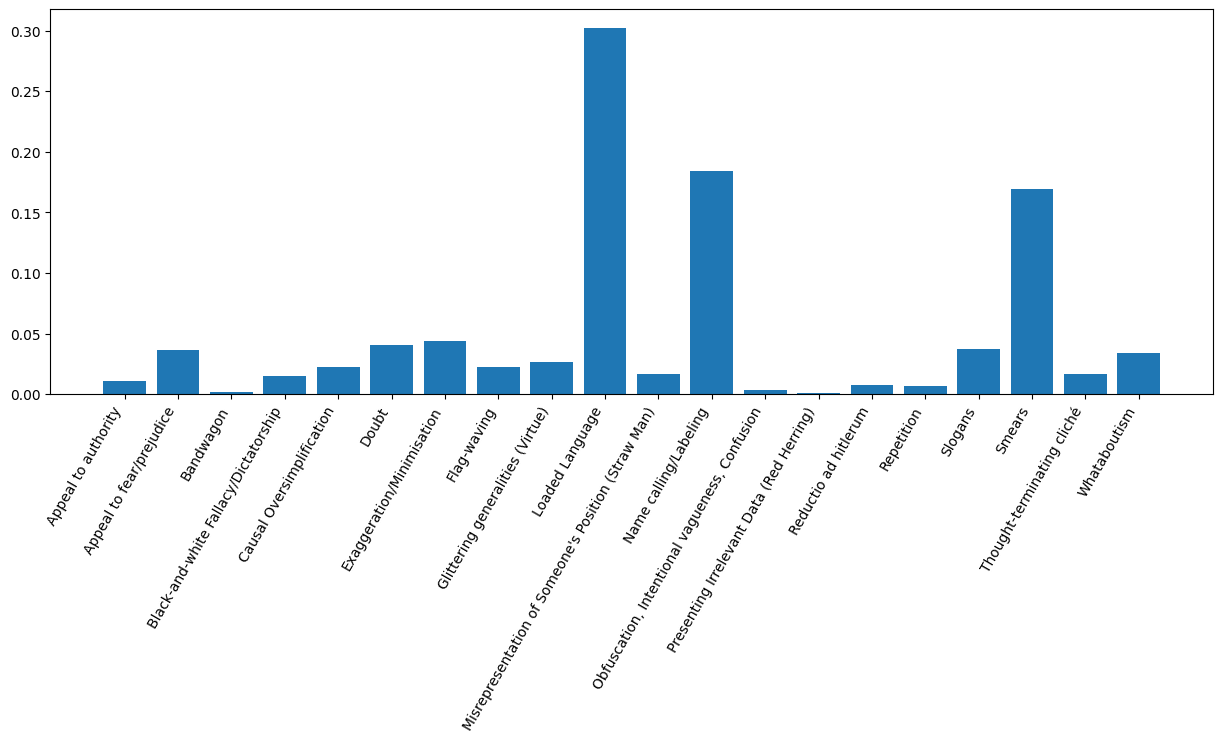

In [22]:
label_dist = torch.sum(dataset_train1_BERT.y, axis=0)
label_dist_norm = label_dist / torch.sum(label_dist)
fig = plt.figure(figsize=(15, 5))
plt.bar(labels_name1, label_dist_norm)
plt.xticks(rotation=60, ha="right");

# Baseline Random Forest

In [23]:
# vectorization removes all words that appear only once in the dataset
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit(
    np.concatenate(
        [dataset_train1_baseline.X, dataset_val1_baseline.X, dataset_test1_baseline.X]
    )
)
X_train = vectorizer.transform(dataset_train1_baseline.X)
X_val = vectorizer.transform(dataset_val1_baseline.X)
X_test = vectorizer.transform(dataset_test1_baseline.X)

In [24]:
model = RandomForestClassifier(
    n_estimators=200,
    criterion="entropy",
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=21,
    max_samples=1.0,
)

In [25]:
grid_search_classification = GridSearchCV(
    model,
    {"min_samples_leaf": [20, 50, 100], "max_samples": [0.3, 0.5, 1]},
    cv=5,
    scoring="f1_micro",
    verbose=1,
    n_jobs=-1,
)

grid_search_classification.fit(X_train, dataset_train1_baseline.y)

print("Best parameters for our model:")
print(grid_search_classification.best_params_)
print("F1 score for the best model:")
print(grid_search_classification.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for our model:
{'max_samples': 0.3, 'min_samples_leaf': 50}
F1 score for the best model:
0.38415685976230024


In [26]:
predictions = torch.tensor(grid_search_classification.predict(X_val))
macro_f1_val = f1_score(
    dataset_val1_baseline.y, predictions, average="macro", zero_division=1
)
micro_f1_val = f1_score(
    dataset_val1_baseline.y, predictions, average="micro", zero_division=1
)

print("Validation set")
print("Macro-F1:")
print(format(macro_f1_val, ".5f"))
print("Micro-F1:")
print(format(micro_f1_val, ".5f"))

Validation set
Macro-F1:
0.18298
Micro-F1:
0.33333


In [27]:
predictions = torch.tensor(grid_search_classification.predict(X_test))
macro_f1 = f1_score(
    dataset_test1_baseline.y, predictions, average="macro", zero_division=1
)
micro_f1 = f1_score(
    dataset_test1_baseline.y, predictions, average="micro", zero_division=1
)

print("Test set")
print("Macro-F1:")
print(format(macro_f1, ".5f"))
print("Micro-F1:")
print(format(micro_f1, ".5f"))

Test set
Macro-F1:
0.03333
Micro-F1:
0.37383


# Model implementation


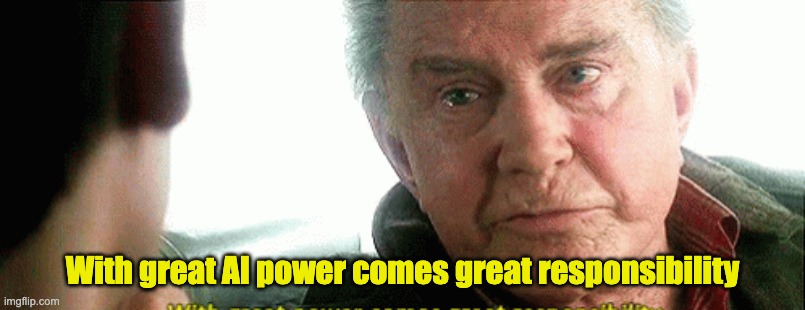

In [28]:
%%capture
bert = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=NUM_LABELS
)
model_bert = PLMClassifier(bert)
roberta = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=NUM_LABELS
)
model_roberta = PLMClassifier(roberta)
xlnet = AutoModelForSequenceClassification.from_pretrained(
    "xlnet-base-cased", num_labels=NUM_LABELS
)
model_xlnet = PLMClassifier(xlnet)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for prediction

#Training example

In [29]:
EPOCHS = 10

# define the logger object
logger1 = TensorBoardLogger("tb_logs", name="BERTClassifier", log_graph=True)
checkpoint_callback1 = ModelCheckpoint(monitor="val_loss")


if torch.cuda.is_available():
    trainer1 = pl.Trainer(
        devices=1,
        accelerator="auto",
        max_epochs=EPOCHS,
        logger=logger1,
        check_val_every_n_epoch=1,
        gradient_clip_val=1.0,
        callbacks=[checkpoint_callback1],
    )
else:
    print("ERROR: a GPU is needed for training")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
# training BERT
trainer1.fit(model_bert, train_loader_BERT, val_loader_BERT)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                          | Params
------------------------------------------------------------
0 | plm       | BertForSequenceClassification | 109 M 
1 | criterion | BCELoss                       | 0     
------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.990   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/tensorboard.py:187: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [32]:
class ckpt_path:
    def __init__(self, path):
        self.best_model_path = path

checkpoint_callback2 = ckpt_path(
    "tb_logs/RoBERTaClassifier/version_0/checkpoints/RoBERTa.ckpt"
)
checkpoint_callback3 = ckpt_path(
    "tb_logs/XLNetClassifier/version_0/checkpoints/XLNet.ckpt"
)

model_roberta = PLMClassifier.load_from_checkpoint(checkpoint_callback2.best_model_path, plm=roberta)

model_xlnet = PLMClassifier.load_from_checkpoint(checkpoint_callback3.best_model_path, plm=xlnet)

# Ensemble
An ensemble is defined using using the class `Ensemble_Classifier` and the five pre-trained models .

In [33]:
ensemble = EnsembleClassifier(
    [model_bert, model_roberta, model_xlnet]
)

# Testing models
The performance metrics used for this this project are the ${Micro-F_1}$ and ${Macro-F_1}$.  
The difference between ${Micro-F_1}$ and ${Macro-F_1}$ scores lies in the way $precision$ and $recall$ are computed: in ${Micro-F_1}$, they are computed from all the
$true\ positives$, $false\ positives$, and $false\ negatives$
over all the labels; for this reason, ${Micro-F_1}$ gives
each sample the same weight, thus giving more
emphasis to the most frequent labels. On the other
hand, ${Macro-F_1}$ is computed as the mean value
among the $F_1-scores$ computed on the different
labels.

## Testing function definition


In [34]:
def test_classifier(model, data_loader, thresholds, n_models=1):
    model.cuda()
    model.eval()
    micro_f1 = []
    macro_f1 = []
    outputs = []
    true_labels = []
    for i, batch in enumerate(data_loader):
        if n_models == 1:
            batch_ids, batch_mask, labels = batch
            true_labels.append(labels)
            outputs.append(model(batch_ids.cuda(), batch_mask.cuda()).detach().cpu())
        else:
            labels = batch[0][2]
            true_labels.append(labels)
            outputs.append(model(batch).detach().cpu())
    true_labels = torch.cat(true_labels)
    outputs = torch.cat(outputs)
    for threshold in thresholds:
        predictions = torch.greater(outputs, torch.ones(outputs.shape) * threshold)
        macro_f1.append(
            f1_score(true_labels, predictions, average="macro", zero_division=1)
        )
        micro_f1.append(
            f1_score(true_labels, predictions, average="micro", zero_division=1)
        )

    return macro_f1, micro_f1

## Validation dataset performance

In [35]:
thresholds = [x / 10 for x in range(0, 11)]

val_table = PrettyTable(["Model", "Micro F-1", "Macro F-1"])
val_table.title = "Validation set results"


macro_f1_bert_val, micro_f1_bert_val = test_classifier(
    model_bert, val_loader_BERT, thresholds
)

macro_f1_roberta_val, micro_f1_roberta_val = test_classifier(
    model_roberta, val_loader_RoBERTa, thresholds
)

macro_f1_xlnet_val, micro_f1_xlnet_val = test_classifier(
    model_xlnet, val_loader_XLNet, thresholds
)


macro_f1_ensemble_val, micro_f1_ensemble_val = test_classifier(
    ensemble, val_loader_ensemble, thresholds, n_models=ensemble.n_models
)

val_table.add_row(
    [
        "BERT",
        str(format(max(micro_f1_bert_val), ".5f")),
        str(format(max(macro_f1_bert_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "RoBERTa",
        str(format(max(micro_f1_roberta_val), ".5f")),
        str(format(max(macro_f1_roberta_val), ".5f")),
    ]
)
val_table.add_row(
    [
        "XLNet",
        str(format(max(micro_f1_xlnet_val), ".5f")),
        str(format(max(macro_f1_xlnet_val), ".5f")),
    ]
)

val_table.add_row(
    [
        "Ensemble",
        str(format(max(micro_f1_ensemble_val), ".5f")),
        str(format(max(macro_f1_ensemble_val), ".5f")),
    ]
)

print(val_table)

+----------------------------------+
|      Validation set results      |
+----------+-----------+-----------+
|  Model   | Micro F-1 | Macro F-1 |
+----------+-----------+-----------+
|   BERT   |  0.58723  |  0.31209  |
| RoBERTa  |  0.59592  |  0.31569  |
|  XLNet   |  0.54286  |  0.26768  |
| Ensemble |  0.60086  |  0.31779  |
+----------+-----------+-----------+


###F1-Micro

Text(0, 0.5, 'f1-micro')

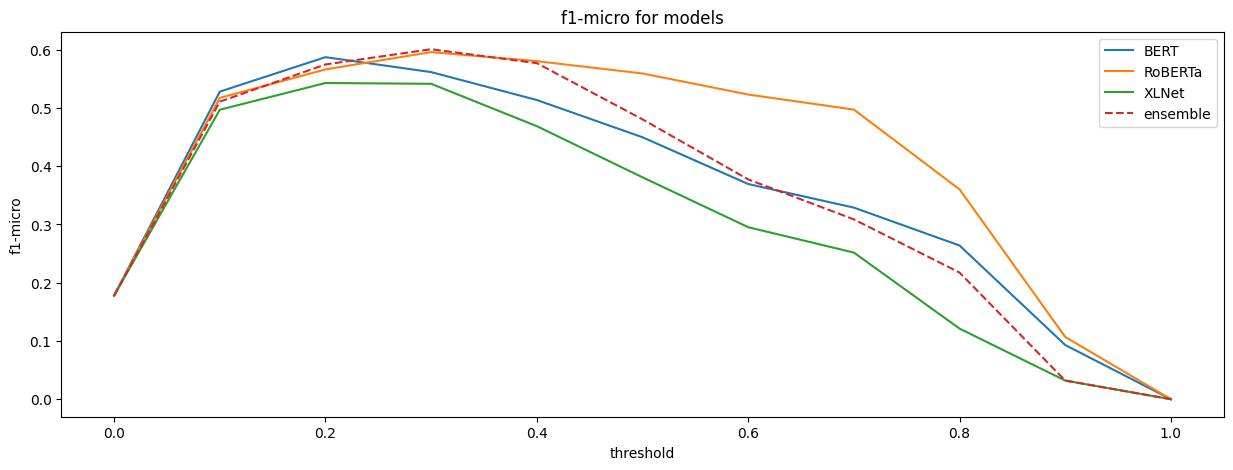

In [36]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, micro_f1_bert_val, label="BERT")
plt.plot(thresholds, micro_f1_roberta_val, label="RoBERTa")
plt.plot(thresholds, micro_f1_xlnet_val, label="XLNet")
plt.plot(thresholds, micro_f1_ensemble_val, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-micro for models")
plt.xlabel("threshold")
plt.ylabel("f1-micro")

###F1-Macro

Text(0, 0.5, 'f1-macro')

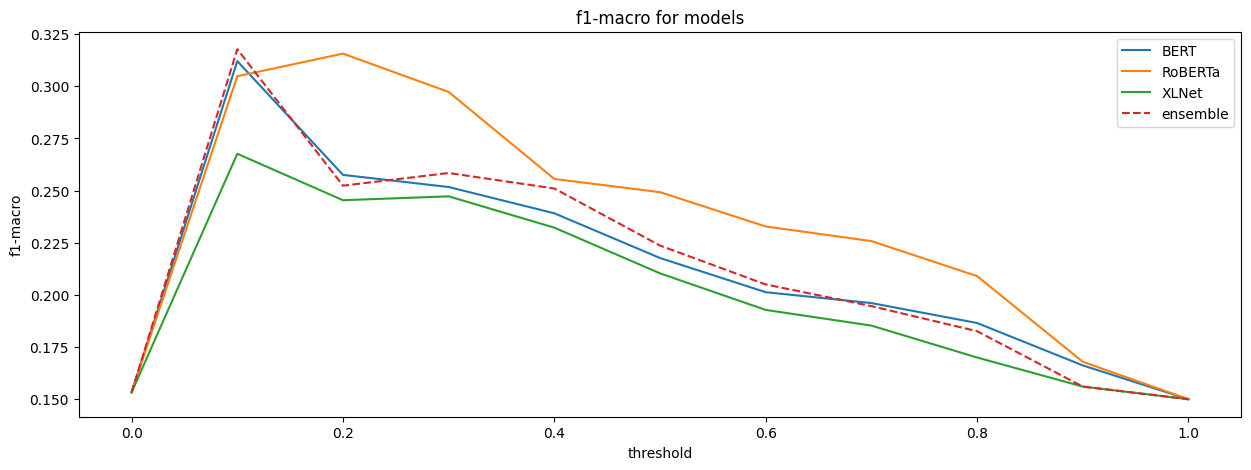

In [37]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, macro_f1_bert_val, label="BERT")
plt.plot(thresholds, macro_f1_roberta_val, label="RoBERTa")
plt.plot(thresholds, macro_f1_xlnet_val, label="XLNet")
plt.plot(thresholds, macro_f1_ensemble_val, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-macro for models")
plt.xlabel("threshold")
plt.ylabel("f1-macro")

## Test dataset performance

In [38]:
thresholds = [x / 10 for x in range(0, 11)]

test_table = PrettyTable(["Model", "Micro F-1", "Macro F-1"])
test_table.title = "Test set results"

macro_f1_bert, micro_f1_bert = test_classifier(model_bert, test_loader_BERT, thresholds)

macro_f1_roberta, micro_f1_roberta = test_classifier(
    model_roberta, test_loader_RoBERTa, thresholds
)

macro_f1_xlnet, micro_f1_xlnet = test_classifier(
    model_xlnet, test_loader_XLNet, thresholds
)

macro_f1_ensemble, micro_f1_ensemble = test_classifier(
    ensemble, test_loader_ensemble, thresholds, n_models=ensemble.n_models
)

test_table.add_row(
    [
        "BERT",
        str(format(max(micro_f1_bert), ".5f")),
        str(format(max(macro_f1_bert), ".5f")),
    ]
)
test_table.add_row(
    [
        "RoBERTa",
        str(format(max(micro_f1_roberta), ".5f")),
        str(format(max(macro_f1_roberta), ".5f")),
    ]
)
test_table.add_row(
    [
        "XLNet",
        str(format(max(micro_f1_xlnet), ".5f")),
        str(format(max(macro_f1_xlnet), ".5f")),
    ]
)
test_table.add_row(
    [
        "Ensemble",
        str(format(max(micro_f1_ensemble), ".5f")),
        str(format(max(macro_f1_ensemble), ".5f")),
    ]
)

print(test_table)

+----------------------------------+
|         Test set results         |
+----------+-----------+-----------+
|  Model   | Micro F-1 | Macro F-1 |
+----------+-----------+-----------+
|   BERT   |  0.48845  |  0.13651  |
| RoBERTa  |  0.48276  |  0.13781  |
|  XLNet   |  0.46870  |  0.13651  |
| Ensemble |  0.50799  |  0.13651  |
+----------+-----------+-----------+


###F-1 Micro

Text(0, 0.5, 'f1-micro')

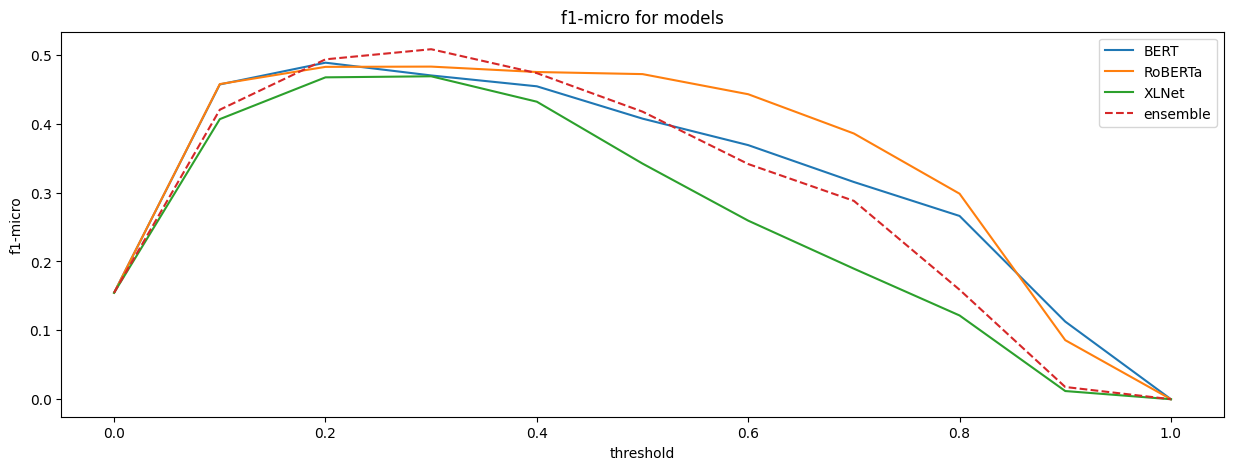

In [39]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, micro_f1_bert, label="BERT")
plt.plot(thresholds, micro_f1_roberta, label="RoBERTa")
plt.plot(thresholds, micro_f1_xlnet, label="XLNet")
plt.plot(thresholds, micro_f1_ensemble, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-micro for models")
plt.xlabel("threshold")
plt.ylabel("f1-micro")

###F-1 Macro

Text(0, 0.5, 'f1-macro')

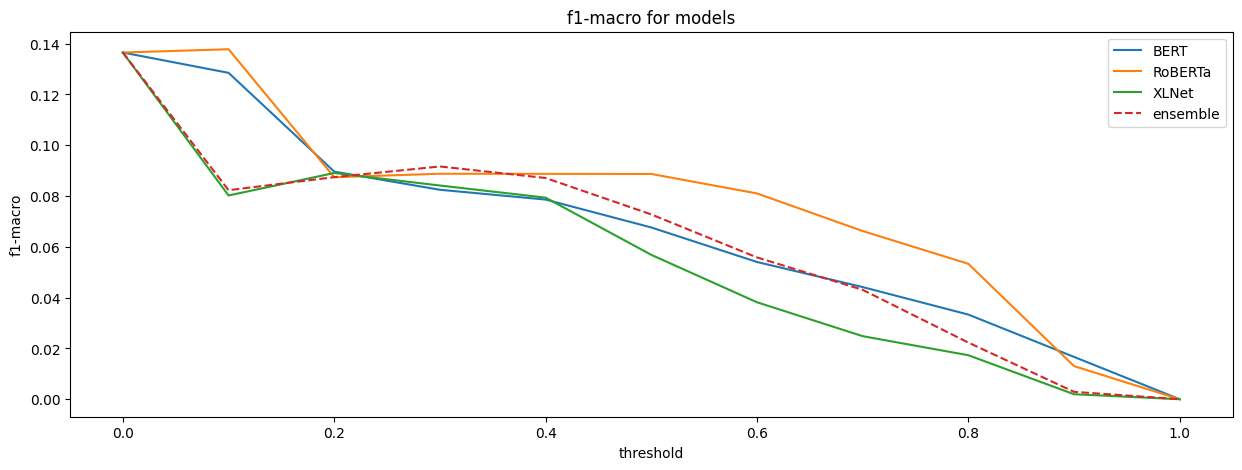

In [40]:
fig = plt.figure(figsize=(15, 5))
thresholds = [x / 10 for x in range(0, 11)]
plt.plot(thresholds, macro_f1_bert, label="BERT")
plt.plot(thresholds, macro_f1_roberta, label="RoBERTa")
plt.plot(thresholds, macro_f1_xlnet, label="XLNet")
plt.plot(thresholds, macro_f1_ensemble, "--", label="ensemble")
plt.legend(loc="best")
plt.title("f1-macro for models")
plt.xlabel("threshold")
plt.ylabel("f1-macro")